In [495]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "./AAME.csv"
df = pd.read_csv(file_path) 

In [497]:
print(df)

             Date  Open  High   Low  Close  Adj Close  Volume
0      1980-03-17  0.00  4.05  3.85   3.85   3.213167   15000
1      1980-03-18  0.00  4.00  3.80   3.80   3.171437   10200
2      1980-03-19  0.00  4.05  3.85   3.85   3.213167   33500
3      1980-03-20  0.00  4.00  3.80   3.80   3.171437    8700
4      1980-03-21  0.00  3.95  3.75   3.75   3.129709   12700
...           ...   ...   ...   ...    ...        ...     ...
10093  2020-03-26  2.29  2.29  2.08   2.28   2.280000    1600
10094  2020-03-27  2.25  2.25  2.21   2.25   2.250000     500
10095  2020-03-30  2.25  2.25  2.13   2.13   2.130000     400
10096  2020-03-31  2.11  2.11  2.11   2.11   2.110000     300
10097  2020-04-01  2.11  2.15  2.11   2.15   2.150000     600

[10098 rows x 7 columns]


In [499]:
print(df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [501]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [503]:
print(X.shape)
print(y.shape)

(10088, 10, 6)
(10088,)


In [505]:
X, y = create_sequences(features_scaled, target, seq_length=10)

In [507]:
#훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [509]:
def create_sequences(data, target, seq_length=10):
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(Xs), np.array(ys)

In [511]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [513]:
batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(StockDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [515]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)

model = RNNModel(input_size=6, hidden_size=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [517]:
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 7.5568
Epoch 2, Loss: 2.8695
Epoch 3, Loss: 1.1564
Epoch 4, Loss: 0.5449
Epoch 5, Loss: 0.2839
Epoch 6, Loss: 0.1728
Epoch 7, Loss: 0.1190
Epoch 8, Loss: 0.0860
Epoch 9, Loss: 0.0689
Epoch 10, Loss: 0.0579
Epoch 11, Loss: 0.0499
Epoch 12, Loss: 0.0449
Epoch 13, Loss: 0.0397
Epoch 14, Loss: 0.0378
Epoch 15, Loss: 0.0350
Epoch 16, Loss: 0.0342
Epoch 17, Loss: 0.0308
Epoch 18, Loss: 0.0318
Epoch 19, Loss: 0.0275
Epoch 20, Loss: 0.0271


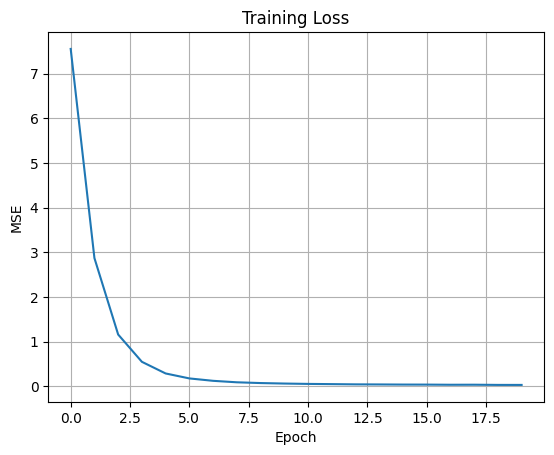

In [518]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.show()

In [519]:
def train_model_with_loss(hidden_size, learning_rate, input_size=6, num_epochs=10):
    model = RNNModel(input_size=input_size, hidden_size=hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
    return train_losses

In [520]:
hidden_sizes = [16, 32, 64]
learning_rates = [0.001, 0.0005]

results = {}
for hs in hidden_sizes:
    for lr in learning_rates:
        print(f" hidden_size={hs}, lr={lr}")
        final_loss = train_model(hs, lr)
        results[(hs, lr)] = final_loss
        print(f"  → Final Loss: {final_loss:.4f}")

 hidden_size=16, lr=0.001
  → Final Loss: 0.2164
 hidden_size=16, lr=0.0005
  → Final Loss: 0.8516
 hidden_size=32, lr=0.001
  → Final Loss: 0.0744
 hidden_size=32, lr=0.0005
  → Final Loss: 0.1714
 hidden_size=64, lr=0.001
  → Final Loss: 0.0401
 hidden_size=64, lr=0.0005
  → Final Loss: 0.0648


 Training with hidden_size=16, lr=0.001
 Training with hidden_size=16, lr=0.0005
 Training with hidden_size=32, lr=0.001
 Training with hidden_size=32, lr=0.0005
 Training with hidden_size=64, lr=0.001
 Training with hidden_size=64, lr=0.0005


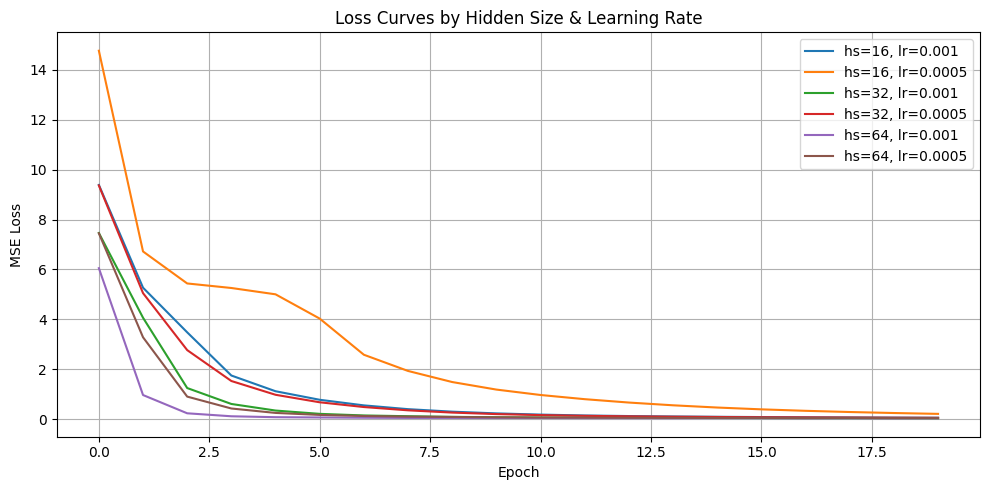

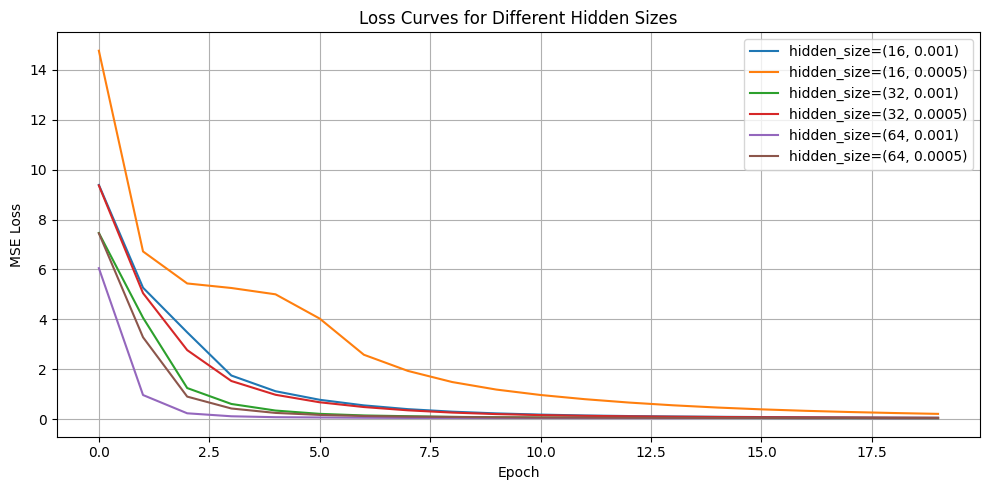

In [521]:
all_loss_curves = {}
for hs in hidden_sizes:
    for lr in learning_rates:
        print(f" Training with hidden_size={hs}, lr={lr}")
        losses = train_model_with_loss(hidden_size=hs, learning_rate=lr, num_epochs=20)
        all_loss_curves[(hs, lr)] = losses

plt.figure(figsize=(10, 5))
for (hs, lr), losses in all_loss_curves.items():
    plt.plot(losses, label=f"hs={hs}, lr={lr}")
plt.title("Loss Curves by Hidden Size & Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for hs, losses in all_loss_curves.items():
    plt.plot(losses, label=f"hidden_size={hs}")
plt.title("Loss Curves for Different Hidden Sizes")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [522]:
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds.append(model(xb).numpy())
        actuals.append(yb.numpy())
y_preds = np.vstack(preds)
y_true = np.vstack(actuals)

In [526]:
rmse = root_mean_squared_error(y_true, y_preds)
mae = mean_absolute_error(y_true, y_preds)
print(f"\nRMSE: {rmse:.4f}, MAE: {mae:.4f}")


RMSE: 0.1797, MAE: 0.1230


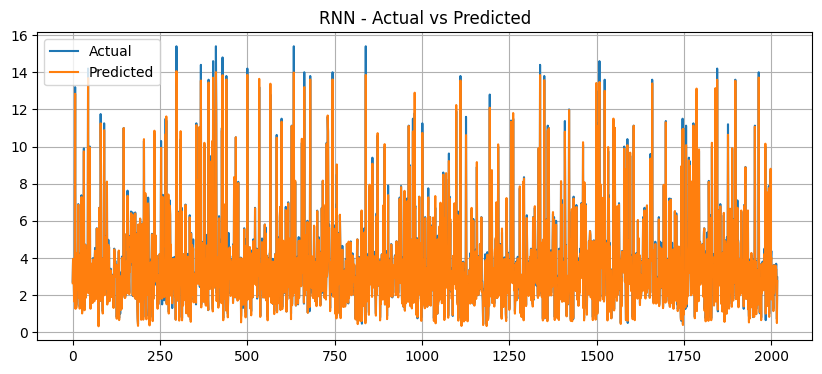

In [527]:
plt.figure(figsize=(10,4))
plt.plot(y_true, label='Actual')
plt.plot(y_preds, label='Predicted')
plt.title('RNN - Actual vs Predicted')
plt.legend()
plt.grid()
plt.show()

In [529]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # 초기 hidden, cell state 생성
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

In [530]:
def train_lstm_model(hidden_size, learning_rate, input_size=6, num_epochs=20):
    model = LSTMModel(input_size=input_size, hidden_size=hidden_size)
    model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")), yb.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
    return model, train_losses

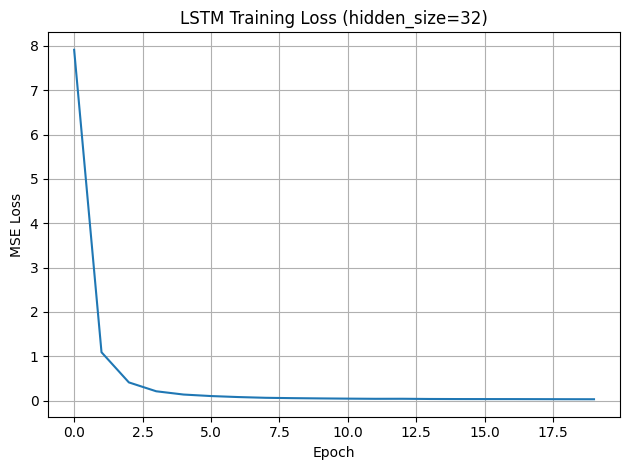

In [531]:
learning_rate = 0.001
lstm_model, lstm_train_losses = train_lstm_model(hidden_size, learning_rate)

import matplotlib.pyplot as plt

plt.plot(lstm_train_losses)
plt.title(f"LSTM Training Loss (hidden_size={hidden_size})")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [532]:
def train_lstm_model_with_loss(hidden_size, learning_rate, input_size=6, num_epochs=20):
    model = LSTMModel(input_size=input_size, hidden_size=hidden_size)
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
    return model, train_losses

In [533]:
lstm_loss_curves = {}
lstm_models = {}
hidden_sizes = [16, 32, 64]
learning_rate = 0.001
num_epochs = 20

for hs in hidden_sizes:
    print(f"Training LSTM: hidden_size={hs}")
    model, losses = train_lstm_model_with_loss(hidden_size=hs, learning_rate=learning_rate, num_epochs=num_epochs)
    lstm_models[hs] = model
    lstm_loss_curves[hs] = losses

Training LSTM: hidden_size=16
Training LSTM: hidden_size=32
Training LSTM: hidden_size=64


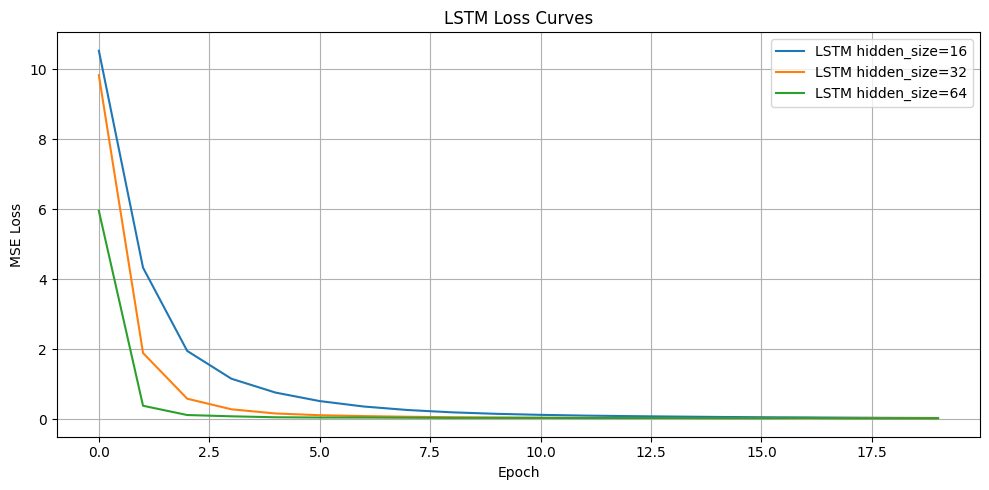

In [534]:
plt.figure(figsize=(10, 5))
for hs, losses in lstm_loss_curves.items():
    plt.plot(losses, label=f"LSTM hidden_size={hs}")
plt.title("LSTM Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [535]:
lstm_model = lstm_models[64] 

lstm_model.eval()
lstm_preds, lstm_actuals = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        lstm_preds.append(lstm_model(xb).cpu().numpy())
        lstm_actuals.append(yb.cpu().numpy())

lstm_y_preds = np.vstack(lstm_preds)
lstm_y_true = np.vstack(lstm_actuals)

In [536]:
lstm_rmse = root_mean_squared_error(lstm_y_true, lstm_y_preds)
lstm_mae = mean_absolute_error(lstm_y_true, lstm_y_preds)

print(f"LSTM RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")

LSTM RMSE: 0.1718, MAE: 0.1171


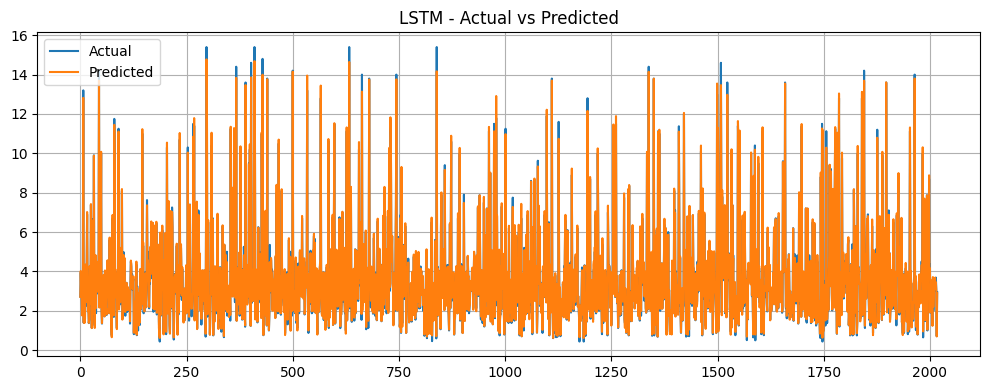

In [537]:
plt.figure(figsize=(10, 4))
plt.plot(lstm_y_true, label='Actual')
plt.plot(lstm_y_preds, label='Predicted')
plt.title('LSTM - Actual vs Predicted')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [573]:
best_lstm_model = lstm_models[32]

In [581]:
def predict_multistep(model, initial_seq, steps=10):
    model.eval()
    preds = []

    input_seq = torch.tensor(initial_seq, dtype=torch.float32).unsqueeze(0)  
    input_size = input_seq.shape[2]

    for _ in range(steps):
        with torch.no_grad():
            out = model(input_seq)  # (1, 1)

        preds.append(out.item())

       
        out_expanded = torch.full((1, input_size), out.item())  

       
        new_input = torch.cat((input_seq[0, 1:], out_expanded), dim=0).unsqueeze(0)  
        input_seq = new_input

    return preds


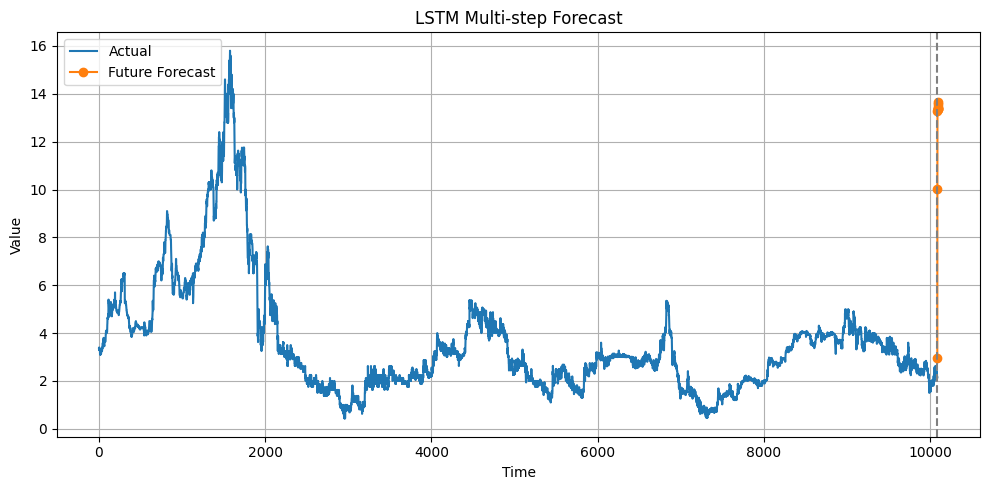

In [583]:
future_preds = predict_multistep(best_lstm_model, X_test[-1], steps=10)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y)), y, label='Actual')  # 전체 실제값
plt.plot(np.arange(len(y), len(y)+10), future_preds, label='Future Forecast', marker='o')
plt.axvline(x=len(y)-1, color='gray', linestyle='--')  # 예측 시작선 표시
plt.title("LSTM Multi-step Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()